In [1]:
import torch.nn.functional as F
import numpy as np
import imageio
import cv2
from third_party import pytorch_ssim
import torch

def mse2psnr(mse):
    """
    :param mse: scalar
    :return:    scalar np.float32
    """
    mse = np.maximum(mse, 1e-10)  # avoid -inf or nan when mse is very small.
    psnr = -10.0 * np.log10(mse)
    return psnr.astype(np.float32)

def compute_metric(pred_image_path, gt_image_path):
    img_pred = imread(pred_image_path) / 255
    img_gt = imread(gt_image_path) / 255
    img_pred = torch.from_numpy(img_pred)
    img_gt = torch.from_numpy(img_gt)
    # mse for the entire image
    mse = F.mse_loss(img_pred, img_gt).item()
    psnr = mse2psnr(mse)
    ssim = pytorch_ssim.ssim(img_pred.permute(2, 0, 1).unsqueeze(0), img_gt.permute(2, 0, 1).unsqueeze(0)).item()
    print(f"psnr:{psnr}, ssim:{ssim}")
    return psnr, ssim

def imread(f):
    rgb = imageio.imread(f)
    if rgb.shape[:2] != (640, 960): 
    # rgb_resized = cv2.resize(rgb, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        rgb = cv2.resize(
                rgb, (960, 640), interpolation=cv2.INTER_LINEAR
        )
    return rgb

/tmp/ipykernel_6499/3304835928.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imageio.imread(f)


psnr:23.593542098999023, ssim:0.7408380408715581
psnr:26.010282516479492, ssim:0.7648424428584186


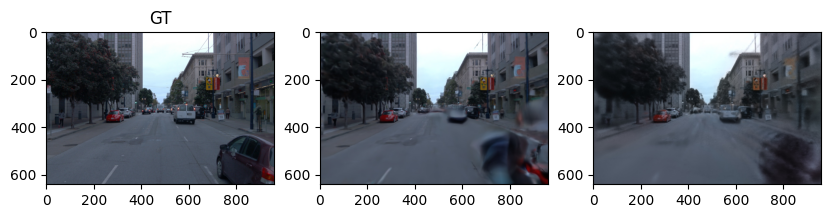

In [5]:
import matplotlib.pyplot as plt
localrf = "/data/ljf/localrf/log/original_resolution/rgb_maps/000_0.jpg"
ours = "/data/ljf/localrf/log/recover/rgb_maps/000_0.jpg"
gt_image_path = "/data/ljf/localrf/waymo_dynamic/waymo/processed/training/016/images/000_0.jpg"

local_metric = compute_metric(localrf, gt_image_path)
ours_metric = compute_metric(ours, gt_image_path)

fig, axes = plt.subplots(1, 3,  figsize=(10, 5))
# for i in [gt_image_path, localrf, ours]:
img = imread(gt_image_path)
axes[0].imshow(img)
axes[0].set_title('GT')

img = imread(localrf)
axes[1].imshow(img)
axes[0].set_title('LocalRF')

# axes[1].set_title('LocalRF: psnr:{:.2f}, ssim:{:.2f}'.format(local_metric[0], local_metric[1]))

img = imread(ours)
axes[2].imshow(img)
axes[0].set_title('Ours')
# axes[2].set_title('Ours: psnr:{:.2f}, ssim:{:.2f}'.format(ours_metric[0], ours_metric[1]))

# plt.tight_layout()


/tmp/ipykernel_6499/3304835928.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imageio.imread(f)


psnr:23.593542098999023, ssim:0.7408380408715581
psnr:26.010282516479492, ssim:0.7648424428584186


Text(0.5, 1.0, 'Ours: psnr:26.01, ssim:0.76')

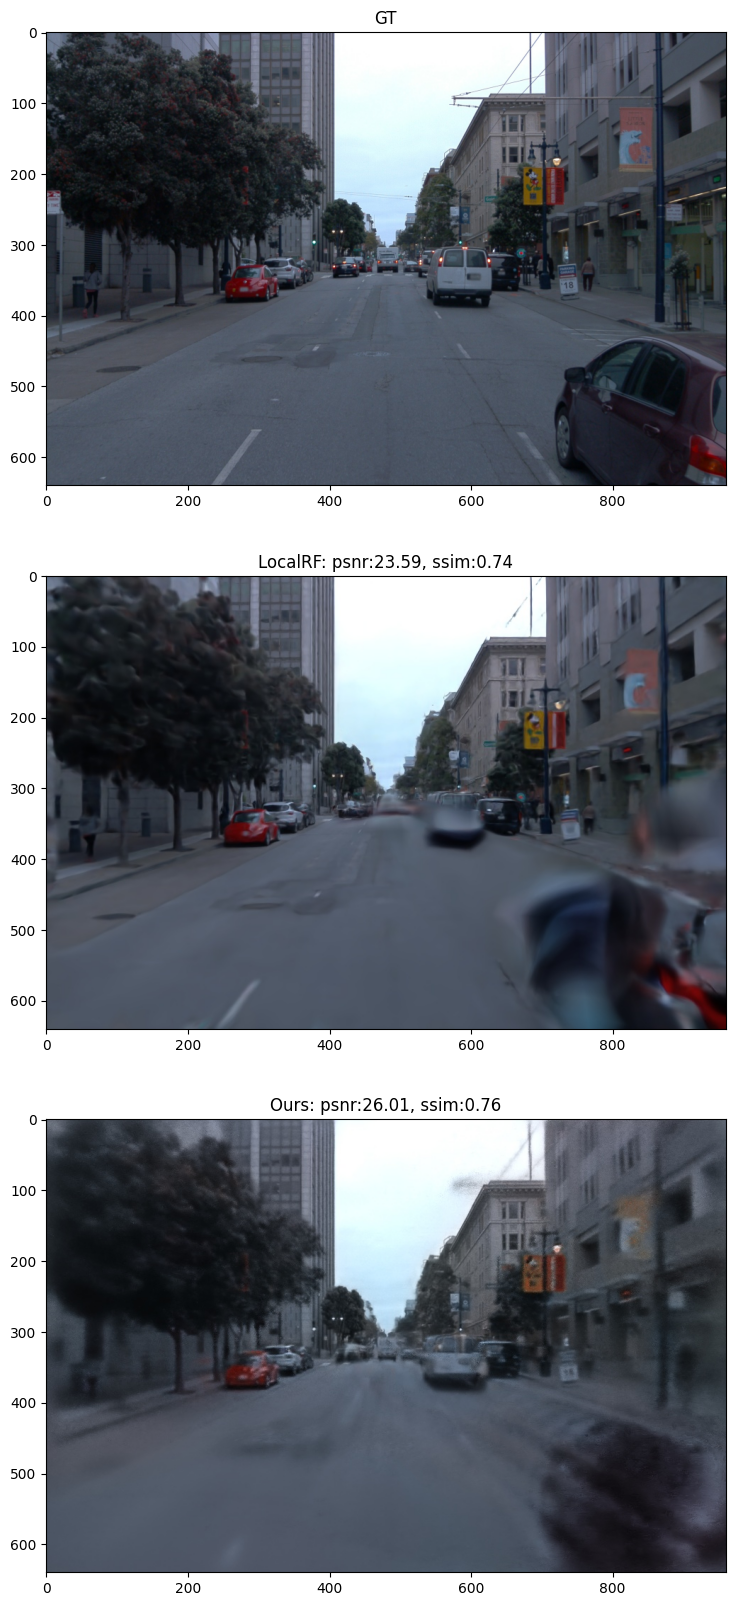

In [25]:
import matplotlib.pyplot as plt
localrf = "/data/ljf/localrf/log/original_resolution/rgb_maps/000_0.jpg"
ours = "/data/ljf/localrf/log/recover/rgb_maps/000_0.jpg"
gt_image_path = "/data/ljf/localrf/waymo_dynamic/waymo/processed/training/016/images/000_0.jpg"

local_metric = compute_metric(localrf, gt_image_path)
ours_metric = compute_metric(ours, gt_image_path)

fig, axes = plt.subplots(3, 1, figsize=(40, 20))

img = imread(gt_image_path)
axes[0].imshow(img)
axes[0].set_title('GT')

img = imread(localrf)
axes[1].imshow(img)
axes[1].set_title('LocalRF: psnr:{:.2f}, ssim:{:.2f}'.format(local_metric[0], local_metric[1]))

img = imread(ours)
axes[2].imshow(img)
axes[2].set_title('Ours: psnr:{:.2f}, ssim:{:.2f}'.format(ours_metric[0], ours_metric[1]))


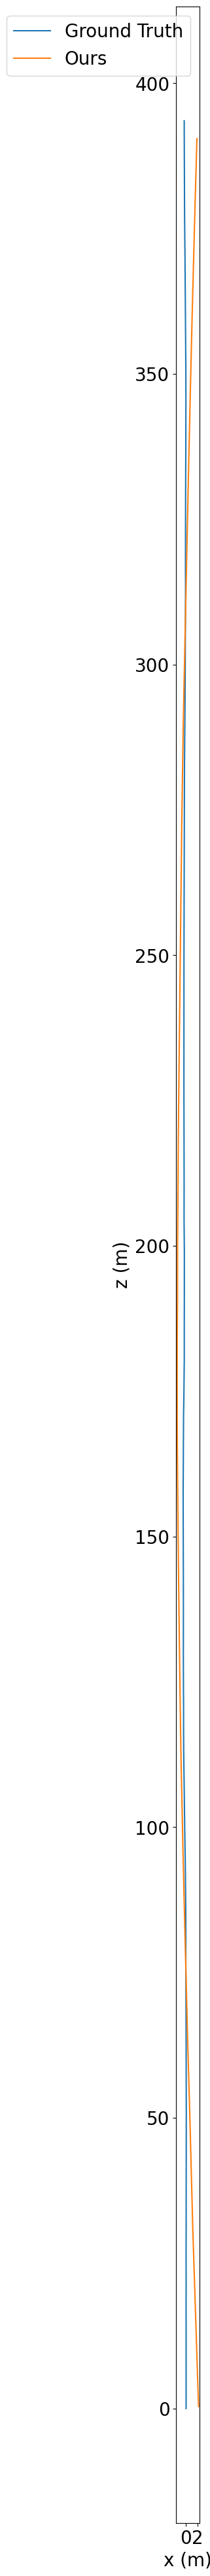

In [34]:
#对齐位姿
import matplotlib.pyplot as plt
import numpy as np
import torch

def plotPath(seq, poses_gt, poses_result):
    plot_keys = ["Ground Truth", "Ours"]
    fontsize_ = 20
    plot_num =-1

    poses_dict = {}
    poses_dict["Ground Truth"] = poses_gt
    poses_dict["Ours"] = poses_result

    fig = plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal')

    for key in plot_keys:
        pos_xz = []
        # for pose in poses_dict[key]:
        for frame_idx in range(len(poses_dict[key])):
            pose = poses_dict[key][frame_idx]
            pos_xz.append([pose[0,3],  pose[2,3]])
        pos_xz = np.asarray(pos_xz)
        plt.plot(pos_xz[:,0],  pos_xz[:,1], label = key)

    plt.legend(loc="upper right", prop={'size': fontsize_})
    plt.xticks(fontsize=fontsize_)
    plt.yticks(fontsize=fontsize_)
    plt.xlabel('x (m)', fontsize=fontsize_)
    plt.ylabel('z (m)', fontsize=fontsize_)
    fig.set_size_inches(10, 50)
    png_title = "sequence_"+(seq)
    # plt.savefig("./" + png_title + ".pdf", bbox_inches='tight', pad_inches=0)

def umeyama_alignment(x, y, with_scale=False):
    """
    Computes the least squares solution parameters of an Sim(m) matrix
    that minimizes the distance between a set of registered points.
    Umeyama, Shinji: Least-squares estimation of transformation parameters
                     between two point patterns. IEEE PAMI, 1991
    :param x: mxn matrix of points, m = dimension, n = nr. of data points
    :param y: mxn matrix of points, m = dimension, n = nr. of data points
    :param with_scale: set to True to align also the scale (default: 1.0 scale)
    :return: r, t, c - rotation matrix, translation vector and scale factor
    """
    if x.shape != y.shape:
        assert False, "x.shape not equal to y.shape"

    # m = dimension, n = nr. of data points
    m, n = x.shape

    # means, eq. 34 and 35
    mean_x = x.mean(axis=1)
    mean_y = y.mean(axis=1)

    # variance, eq. 36
    # "transpose" for column subtraction
    sigma_x = 1.0 / n * (np.linalg.norm(x - mean_x[:, np.newaxis])**2)

    # covariance matrix, eq. 38
    outer_sum = np.zeros((m, m))
    for i in range(n):
        outer_sum += np.outer((y[:, i] - mean_y), (x[:, i] - mean_x))
    cov_xy = np.multiply(1.0 / n, outer_sum)

    # SVD (text betw. eq. 38 and 39)
    u, d, v = np.linalg.svd(cov_xy)

    # S matrix, eq. 43
    s = np.eye(m)
    if np.linalg.det(u) * np.linalg.det(v) < 0.0:
        # Ensure a RHS coordinate system (Kabsch algorithm).
        s[m - 1, m - 1] = -1

    # rotation, eq. 40
    r = u.dot(s).dot(v)

    # scale & translation, eq. 42 and 41
    c = 1 / sigma_x * np.trace(np.diag(d).dot(s)) if with_scale else 1.0
    t = mean_y - np.multiply(c, r.dot(mean_x))

    return r, t, c

def sixD_to_mtx(r):
    b1 = r[..., 0]
    b1 = b1 / torch.norm(b1, dim=-1)[:, None]
    b2 = r[..., 1] - torch.sum(b1 * r[..., 1], dim=-1)[:, None] * b1
    b2 = b2 / torch.norm(b2, dim=-1)[:, None]
    b3 = torch.cross(b1, b2)

    return torch.stack([b1, b2, b3], dim=-1)

def get_cam2world(r_c2w, t_c2w, view_ids=None, starting_id=0):
    if view_ids is not None:
        r_c2w = torch.stack([r_c2w[view_id] for view_id in view_ids], dim=0)
        t_c2w = torch.stack([t_c2w[view_id] for view_id in view_ids], dim=0)
    else:
        r_c2w = torch.stack(list(r_c2w[starting_id:]), dim=0)
        t_c2w = torch.stack(list(t_c2w[starting_id:]), dim=0)
    new_row = torch.tensor([0, 0, 0, 1], dtype=torch.float).view(1, 1, 4).repeat(r_c2w.shape[0], 1, 1)
    return torch.cat((torch.cat([sixD_to_mtx(r_c2w), t_c2w[..., None]], dim = -1), new_row.to(r_c2w.device)), dim=1)

def read_localrf_poses(path=None):
    state_dict = torch.load(path)

    r_list, t_list = [], []
    for key in state_dict["state_dict"]:
        if "r_c2w" in key:
            r_list.append(state_dict["state_dict"][key])
        if "t_c2w" in key:
            t_list.append(state_dict["state_dict"][key])
    pose_mtx = get_cam2world(r_list, t_list)
    return pose_mtx

pred_path = "/data/ljf/localrf/checkpoints.th"
gt_path = "016_gtposes.txt"
# gt_path = "003_gtposes.txt"
learned_poses = read_localrf_poses(pred_path).detach().cpu().numpy()
pred_path = "kitti_04_pred_poses.txt"
gt_path = "kitti_04_gtposes.txt"
learned_poses = np.loadtxt(pred_path).reshape(-1, 4, 4)
new_row = np.tile(np.array([0, 0, 0, 1], dtype=np.float32), (learned_poses.shape[0], 1, 1))
# new_row = np.array([0, 0, 0, 1], dtype=np.float32).view(1, 1, 4).repeat(learned_poses.shape[0], 1, 1)
gt_poses = np.loadtxt(gt_path).reshape(-1, 3, 4)
gt_poses = np.concatenate([gt_poses, new_row], axis=1)

# Pose alignment to first frame
pred_0 = learned_poses[0]
gt_0 = gt_poses[0]
for cnt in range(len(learned_poses)):
    learned_poses[cnt] = np.linalg.inv(pred_0) @ learned_poses[cnt]
    gt_poses[cnt] = np.linalg.inv(gt_0) @ gt_poses[cnt]

# get XYZ
xyz_gt = []
xyz_result = []
for cnt in range(len(gt_poses)):
    xyz_gt.append([gt_poses[cnt][0, 3], gt_poses[cnt][1, 3], gt_poses[cnt][2, 3]])
    xyz_result.append([learned_poses[cnt][0, 3], learned_poses[cnt][1, 3], learned_poses[cnt][2, 3]])
xyz_gt = np.asarray(xyz_gt).transpose(1, 0)
xyz_result = np.asarray(xyz_result).transpose(1, 0)
r, t, scale = umeyama_alignment(xyz_result, xyz_gt, True)

align_transformation = np.eye(4)
align_transformation[:3:, :3] = r
align_transformation[:3, 3] = t

for cnt in range(len(learned_poses)):
    learned_poses[cnt][:3, 3] *= scale
    learned_poses[cnt] = align_transformation @ learned_poses[cnt]

# Plotting
plotPath("016", gt_poses, learned_poses)
# np.savetxt("016_aligned_poses.txt", learned_poses.reshape(-1, 16))

In [ ]:
# 读取.pt文件，存为txt
import torch